### Vehicle Detection Project
#### The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

### Training Data

In [2]:
car_images = glob.glob('training_dataset/vehicles/**/*.png')
noncar_images = glob.glob('training_dataset/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


### Visualize training data

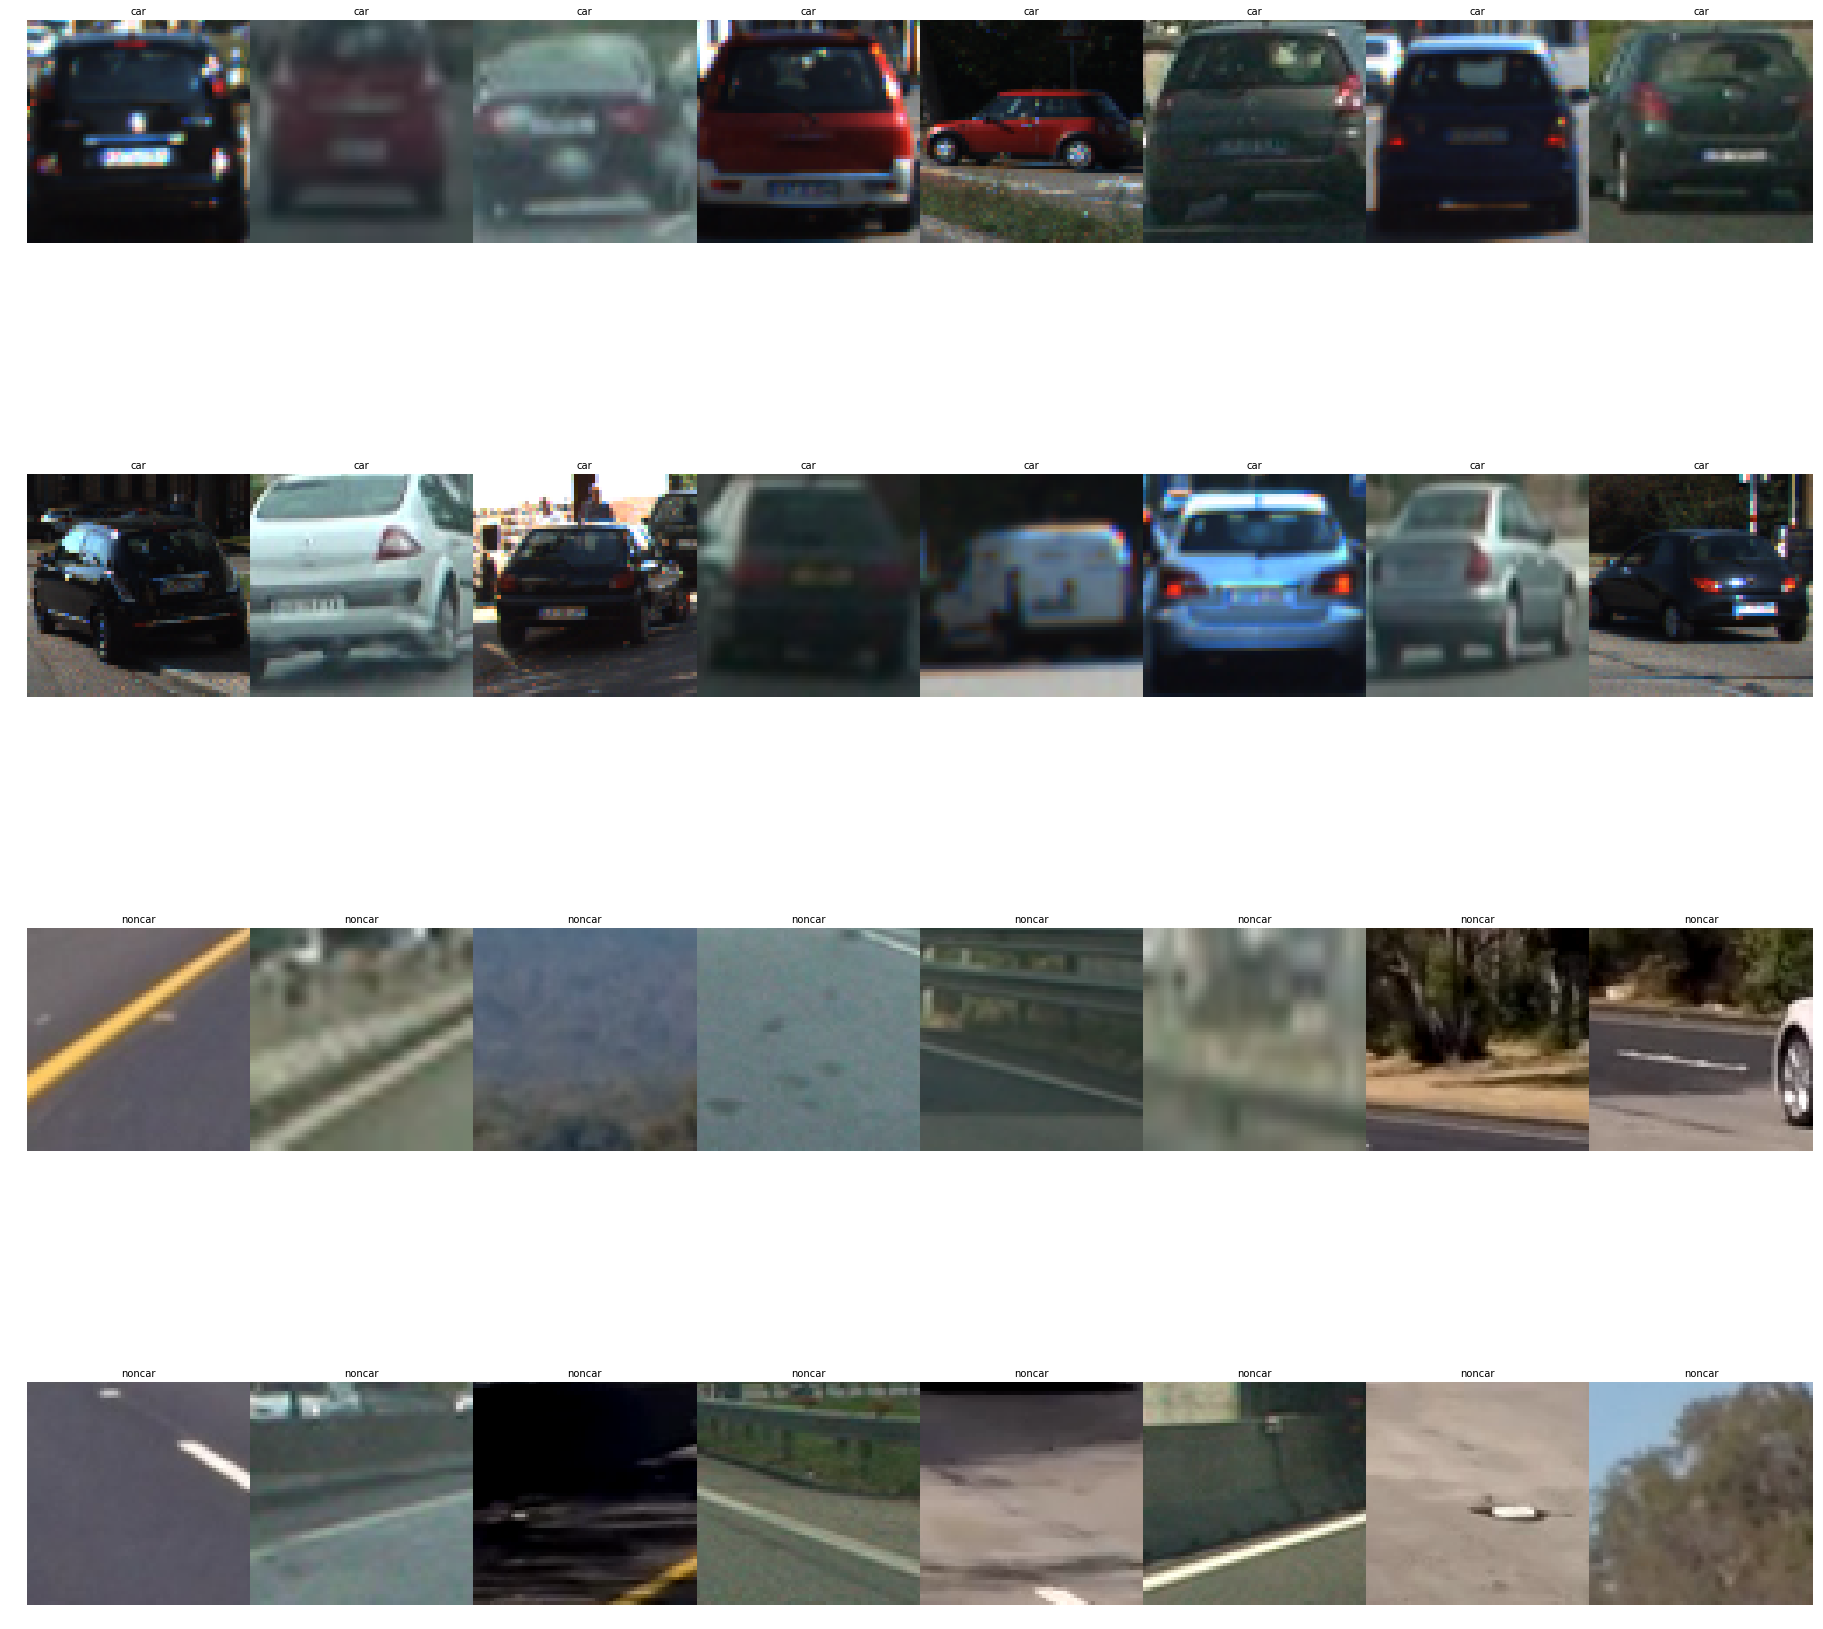

In [3]:
fig, axs = plt.subplots(4,8, figsize=(32, 32))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list of car/non-car images and randomly display them
for i in np.arange(16):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(16,32):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('noncar', fontsize=10)
    axs[i].imshow(img)

### Generic functions

In [4]:
def convert_color(img, conv='RGB2YCrCb'):
    # apply color conversion if other than 'RGB'
    if conv != 'RGB':
        if conv == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif conv == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif conv == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif conv == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif conv == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:  return np.copy(img)  
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


## Histogram of Oriented Gradients (HOG)

### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.


### Get the HOG features from image

In [5]:
# Define a function to return HOG features and visualization
# Hog Feature and Visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features


...


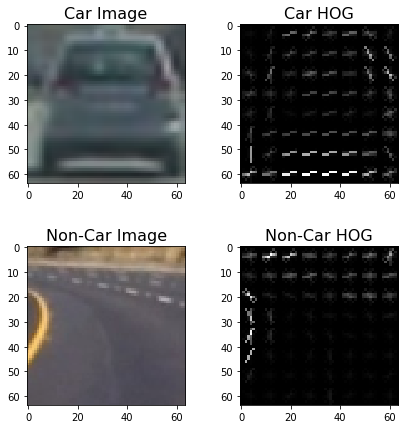

In [6]:
car_img = mpimg.imread(car_images[3])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

noncar_img = mpimg.imread(noncar_images[3])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)


###  Extract HOG Features 

#### Combinations of colorspace, Orient, pix_per_cell, cell_per_block and hog_channel

I tried different combinations of color spaces colorspace, Orient, pix_per_cell, cell_per_block and hog_channel. Increasing the orientation enhanced the accuarcy of the finally trained classifier. For the color space YUV performed better than RGB, HLS, and HSV.

Final parameters are:

* color_space = 'YUV'
* spatial_size=(32, 32)
* hist_bins=32
* orient = 11
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel='ALL'

####  parameters

In [7]:

### TODO: Tweak these parameters and see how the results change.

color_space='YUV'
spatial_size=(32, 32)
hist_bins=32
orient=11
pix_per_cell=16
cell_per_block=2
hog_channel='ALL'
spatial_feat=True
hist_feat=True
hog_feat=True

In [8]:
def extract_features(imgs, color_space='YCrCb', spatial_size=(32, 32), hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True,
                     hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat is True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat is True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat is True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features



In [9]:
# time to run the hog features
t=time.time()
car_features = extract_features(car_images, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(noncar_images, color_space=color_space, spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to extract HOG features...')


73.14 Seconds to extract HOG features...


#### Normalize the feature vectors

In [10]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)



#### Train-Test Split

In [11]:

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [12]:

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4356


####  Model Training

In [13]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()

10.78 Seconds to train SVC...
Test Accuracy of SVC =  0.9887
My SVC predicts:  [ 0.  0.  0.  0.  1.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  1.  1.  1.  0.  1.]


### 2. Sliding Window

In [14]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='YUV')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    rectangles = []

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, rectangles

([], <a list of 0 Text yticklabel objects>)

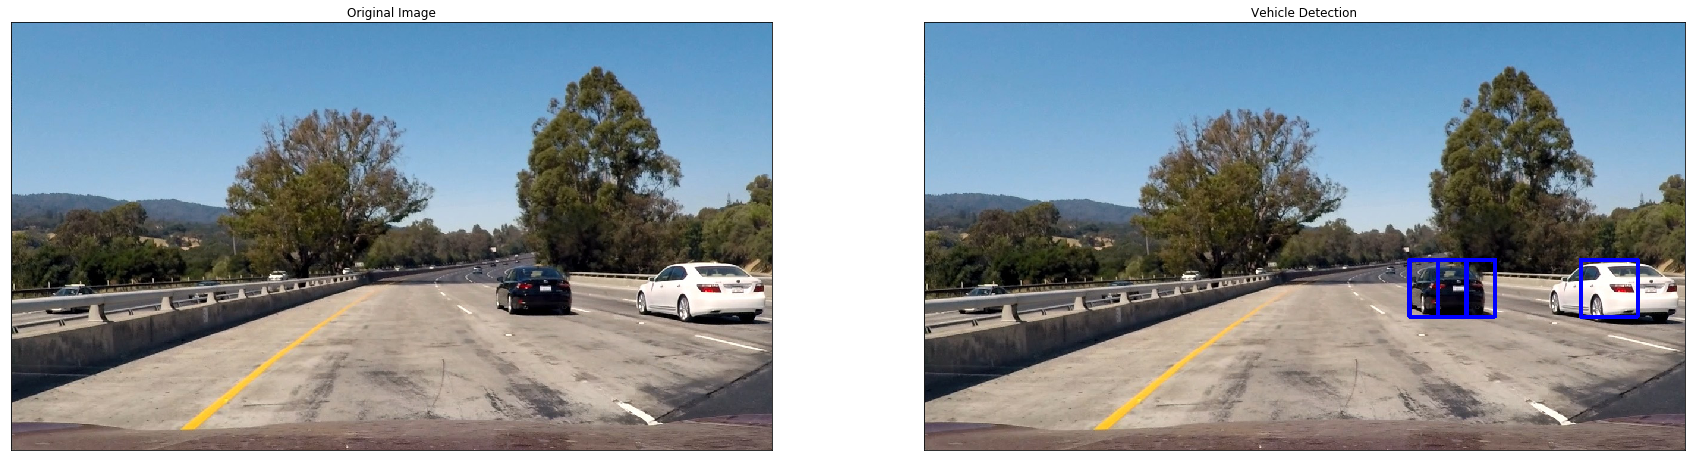

In [15]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

out_img, rect = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


plt.figure(figsize=(30,40))
plt.subplot(121)
plt.imshow(test_img)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(out_img)
plt.title('Vehicle Detection')
plt.xticks([])
plt.yticks([])


### Multi-Scale Search

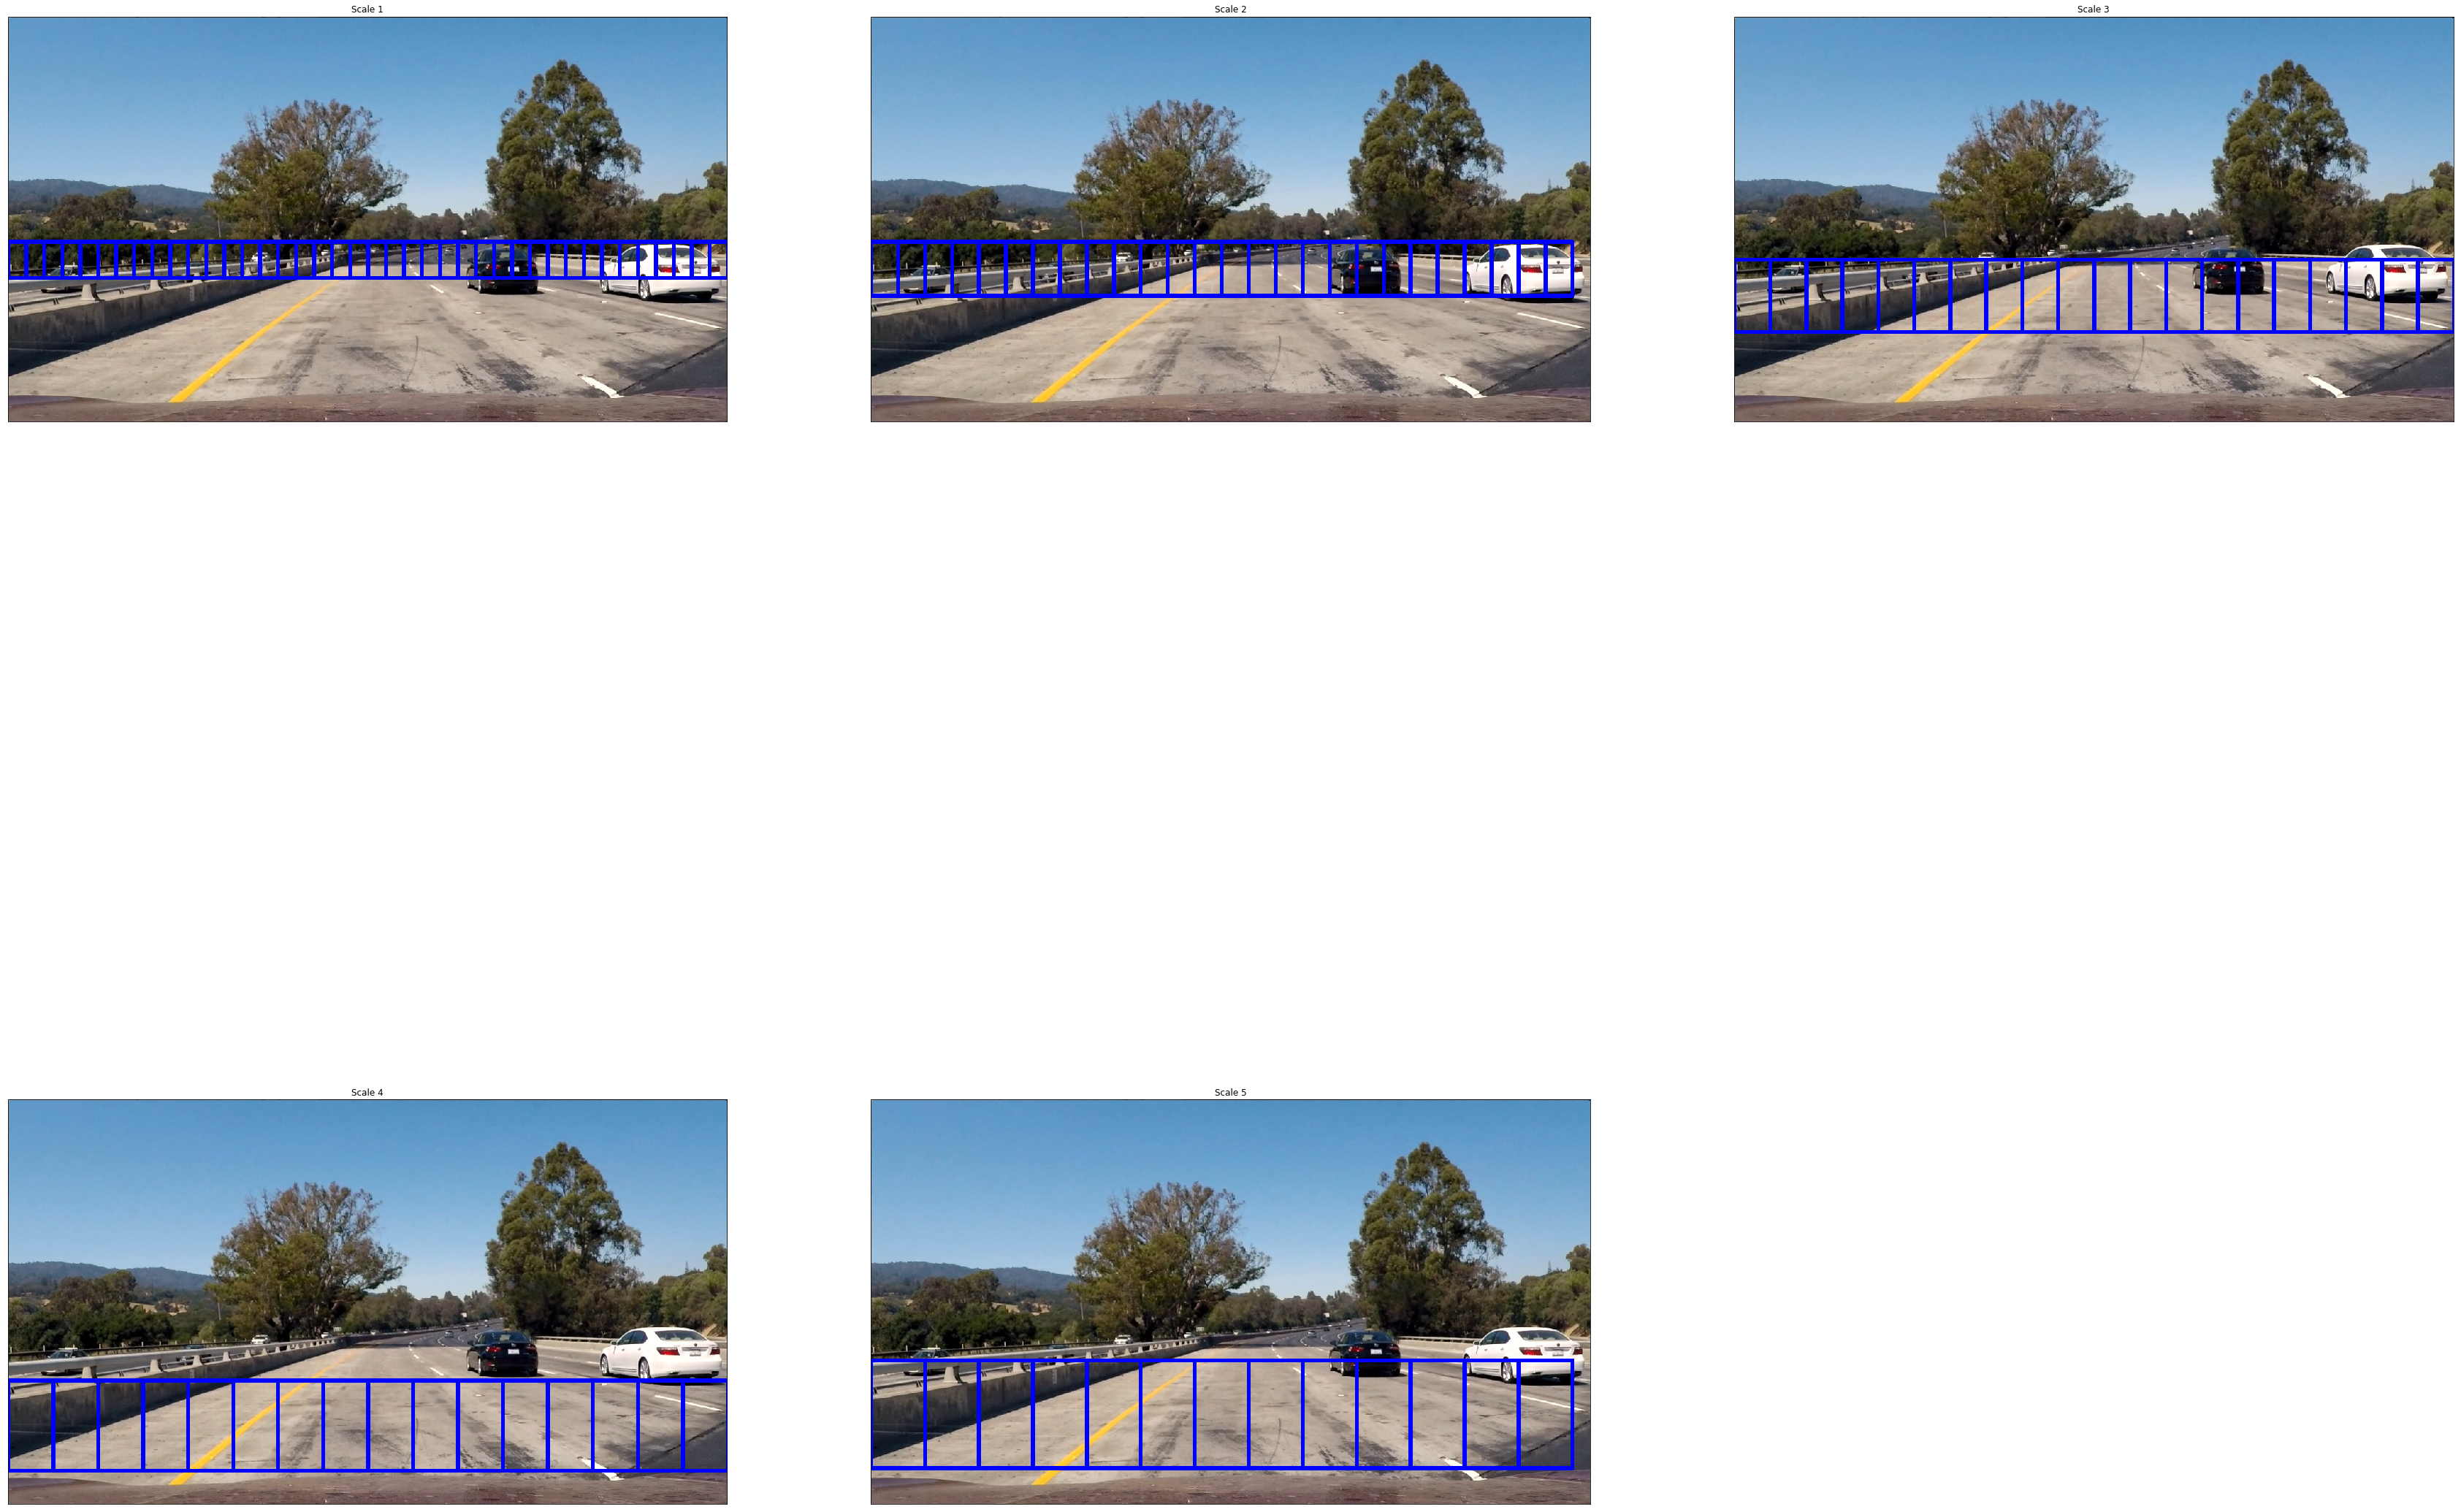

In [16]:
plt.figure(figsize=(60,50))
subpltcount=1
rectangles = []
for (ystart, ystop, scale) in [(400, 464, 1), (400, 496, 1.5), (432, 560, 2), (500, 700, 2.5), (464,660,3)]:
    plt.subplot(2,3,subpltcount)
    out_img, rect = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, True)
    rectangles.append(rect)
    plt.imshow(out_img)
    #plt.imshow(draw_multi_scale_windows(img, ystart, ystop, scale))
    plt.title('Scale %s'%subpltcount)
    plt.xticks([])
    plt.yticks([])
    subpltcount +=1

#### Combine Various Sliding Window Searches

In [17]:
plt.figure(figsize=(60,50))
rectangles = []
for (ystart, ystop, scale) in [(400, 464, 1),(416, 480, 1),(400, 496, 1.5),(432, 528, 1.5),(400, 528, 2), (432, 560, 2), (500, 700, 2.5), (464,660,3)]:
    out_img, rect = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    rectangles.append(rect)



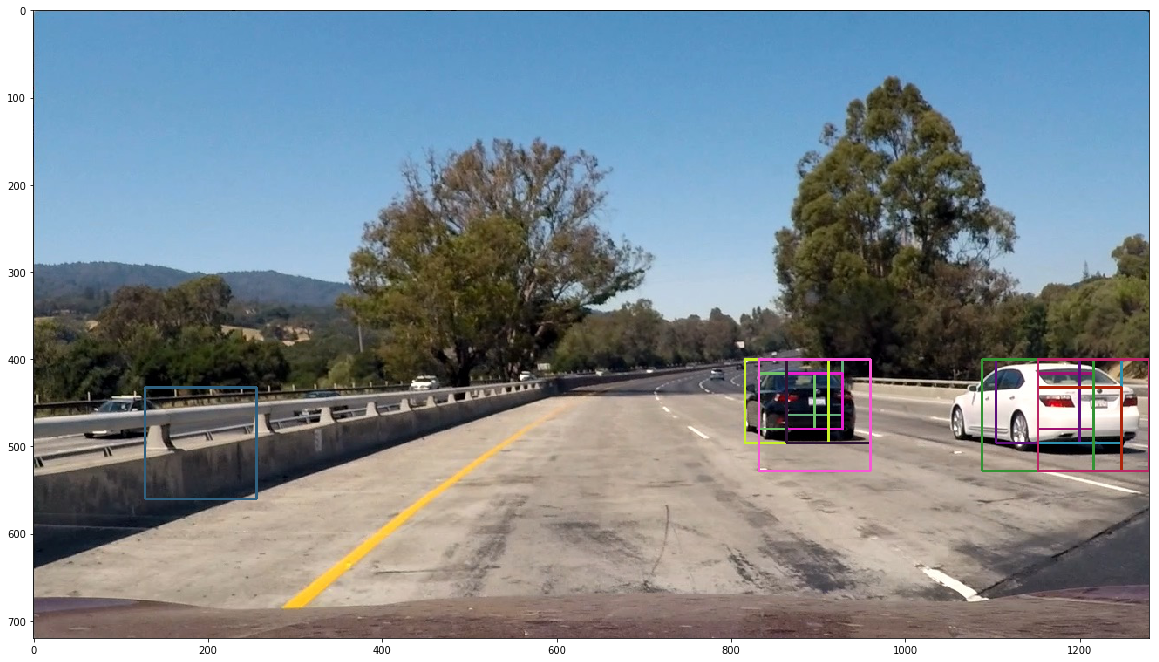

In [18]:
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(20,20))
plt.imshow(test_img_rects)

### False Positives

#### Heatmap

In [19]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


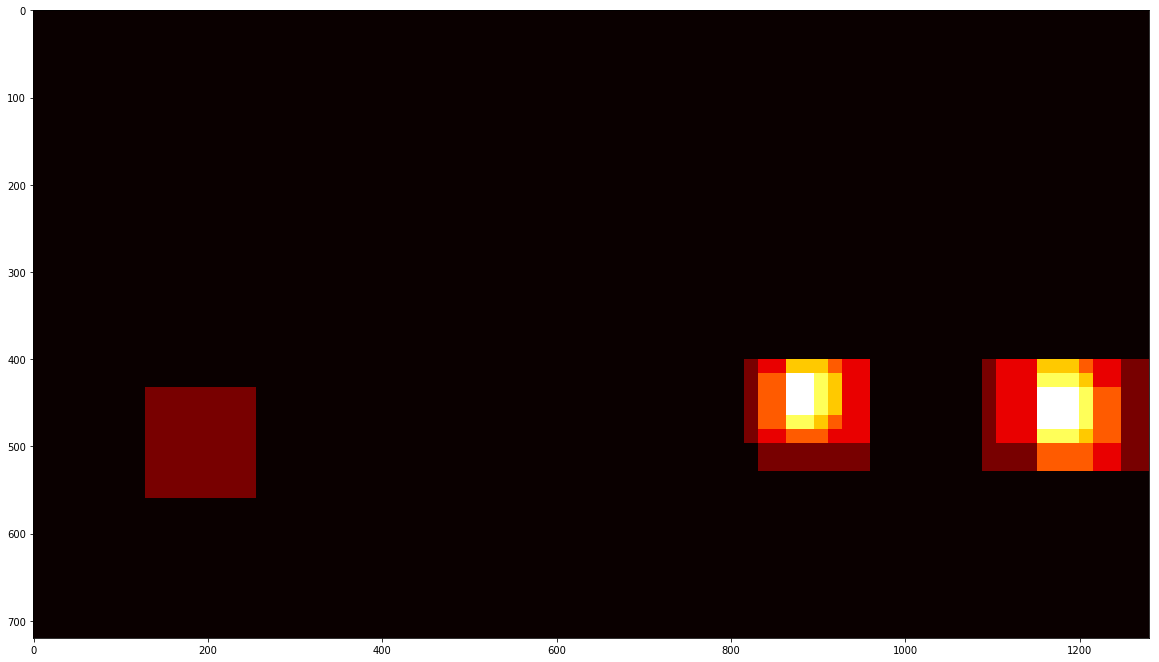

In [20]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(20,20))
plt.imshow(heatmap_img, cmap='hot')


#### Threshold to the Heatmap

In [21]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

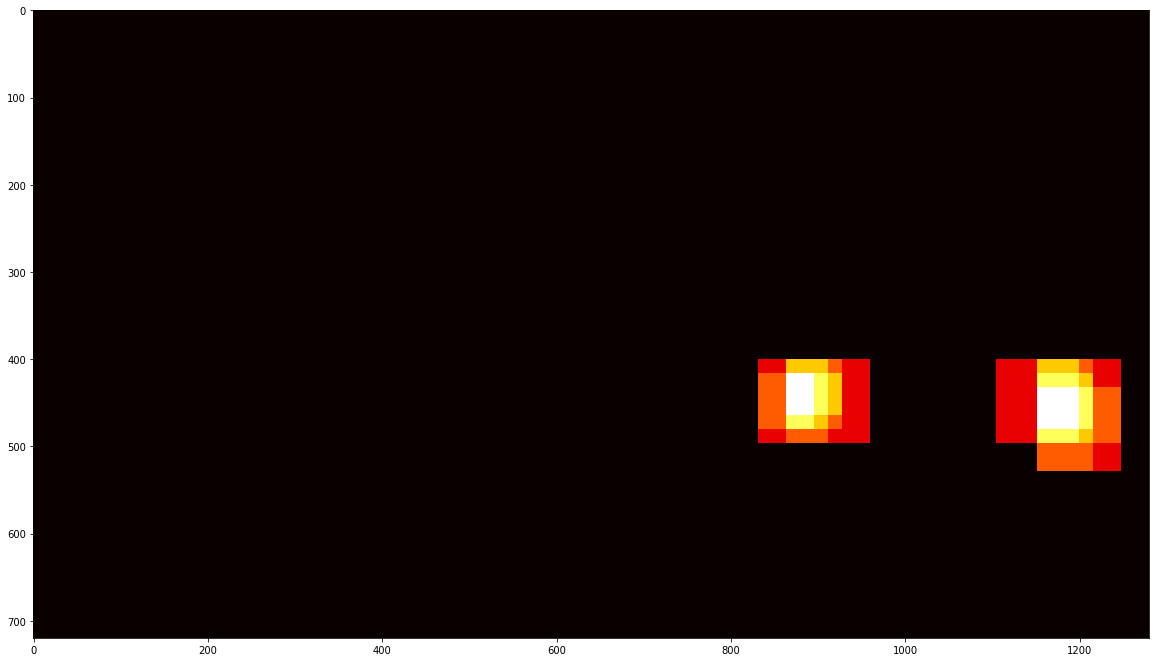

In [22]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(20,20))
plt.imshow(heatmap_img, cmap='hot')

2 cars found


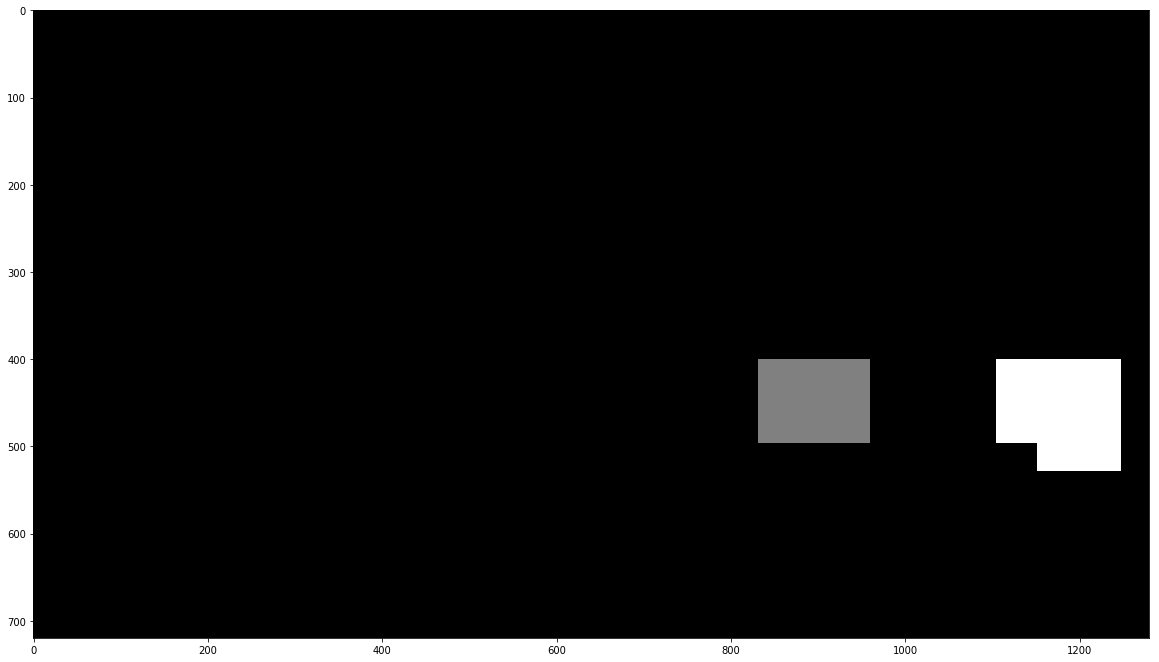

In [23]:
labels = label(heatmap_img)
plt.figure(figsize=(20,20))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

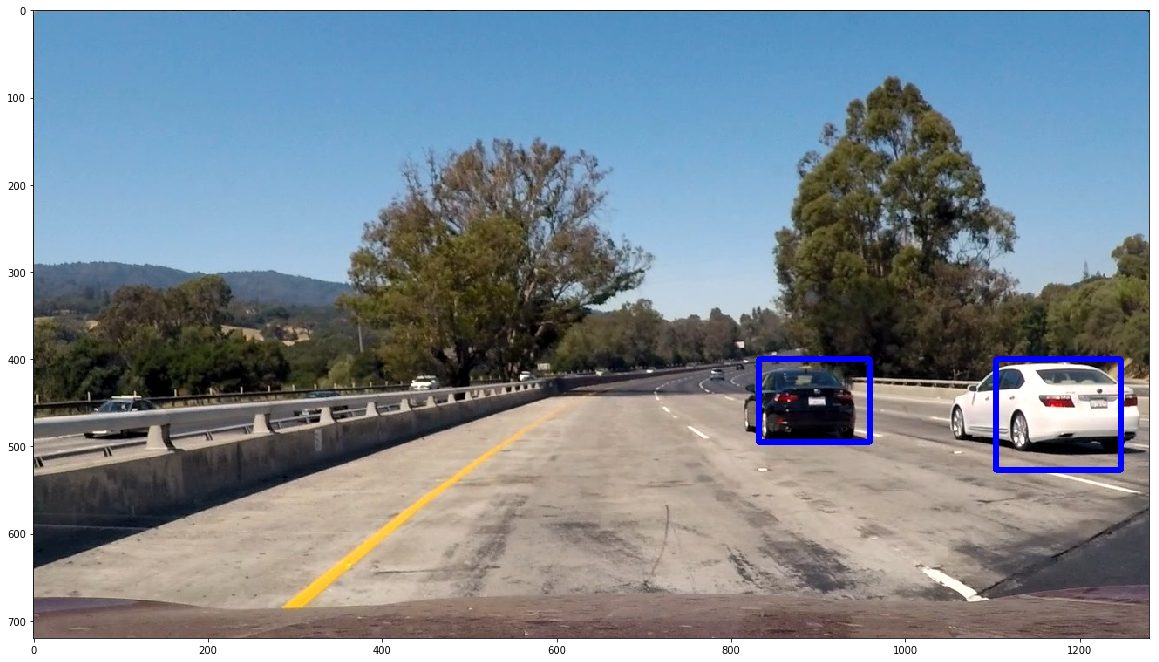

In [24]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(20,20))
plt.imshow(draw_img)

### Pipeline

In [25]:
def process_frames(img):
    rectangles = []
    ystart_ystop_scale = [(400, 464, 1),(416, 480, 1),(400, 496, 1.5),(432, 528, 1.5),(400, 528, 2), (432, 560, 2), (500, 700, 2.5), (464,660,3)]
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL'

    for (ystart, ystop, scale) in [(400, 464, 1),(416, 480, 1),(400, 496, 1.5),(432, 528, 1.5),(400, 528, 2), (432, 560, 2), (500, 700, 2.5), (464,660,3)]:
        out_img, rect = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        rectangles.append(rect)
    rectangles = [item for sublist in rectangles for item in sublist] 
    test_img_rects = draw_boxes(img, rectangles, color='random', thick=2)
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)

    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


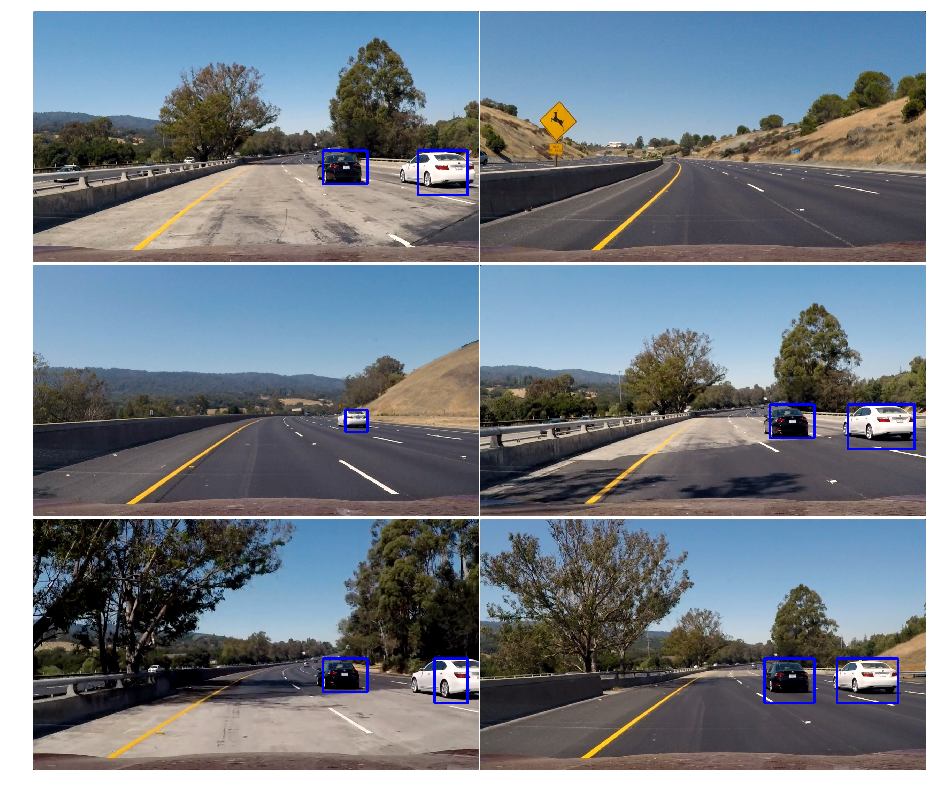

In [26]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frames(mpimg.imread(im)))
    axs[i].axis('off')

### 3. Video Implementation

In [27]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frames)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:17<00:00,  2.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 15.5 s, sys: 1.41 s, total: 16.9 s
Wall time: 18.7 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [29]:
test_out_file2 = 'project_video_out.mp4'
clip_test2 = VideoFileClip('project_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frames)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)



[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [08:56<00:00,  2.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 8min 8s, sys: 45.7 s, total: 8min 54s
Wall time: 8min 57s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file2))

### Define class to filter prev frames

In [31]:
# Class that store data from video frames and throw older frames for better optmization 
class Vehicle_Previous():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 12:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]


In [32]:
def process_frames_for_video(img):

    rectangles = []
    ystart_ystop_scale = [(400, 464, 1),(416, 480, 1),(400, 496, 1.5),(432, 528, 1.5),(400, 528, 2), (432, 560, 2), (500, 700, 2.5), (464,660,3)]

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    for (ystart, ystop, scale) in ystart_ystop_scale:
        out_img, rect = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        rectangles.append(rect)
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        prev.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in prev.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(prev.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

#### Test the test_video/project _video with the new class changes

In [33]:
prev = Vehicle_Previous()

final_test_out_file = 'test_video_out_2.mp4'
clip_final = VideoFileClip('test_video.mp4')
clip_final_out = clip_final.fl_image(process_frames_for_video)
%time clip_final_out.write_videofile(final_test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out_2.mp4
[MoviePy] Writing video test_video_out_2.mp4


 97%|█████████▋| 38/39 [00:16<00:00,  2.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out_2.mp4 

CPU times: user 15 s, sys: 1.41 s, total: 16.4 s
Wall time: 17.8 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(final_test_out_file))

In [ ]:
prev = Vehicle_Previous()

final_test_out_file2 = 'project_video_out.mp4'
clip_final2 = VideoFileClip('project_video.mp4')
clip_final_out2 = clip_final2.fl_image(process_frames_for_video)
%time clip_final_out2.write_videofile(final_test_out_file2, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


 50%|█████     | 633/1261 [04:28<04:06,  2.55it/s]

In [ ]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(final_test_out_file2))